# Climate projections

In [8]:
# basic
import os 
import numpy as np
import xarray as xr
import geopandas as gpd

# climate-related
import intake
import gcsfs
import cftime
from xclim import sdba
from xclim import set_options

# others
from datetime import datetime
from tqdm.notebook import tqdm

#bug in specific gcm
#from xmip.preprocessing import combined_preprocessing

chunks_dict = {"lon": 10, "lat": 10, "time": -1}

import warnings
warnings.simplefilter("ignore") 

# check what gcm to use (not only generic list)
gcm_list  = ["ACCESS-CM2", "CMCC-ESM2", "EC-Earth3", "GFDL-ESM4", "INM-CM5-0", "KACE-1-0-G", "MPI-ESM1-2-HR", "MRI-ESM2-0", "MIROC6", "NorESM2-MM"]
ssp_list  = ["ssp126","ssp245","ssp585"] 
climate   = ["PMET", "CR2MET", "ERA5"]
bias_correction = ["MVA", "DQM", "MBC"]

## 1. Download and preprocess selected GCMs

In [ ]:
url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
dataframe = intake.open_esm_datastore(url)

In [ ]:
dataframe = dataframe.search(experiment_id = ['historical', 'ssp126', 'ssp245', 'ssp585'], # scenarios  
                          table_id      = 'Amon', # time-step
                          variable_id   = ['tas', 'pr'], # variables
                          member_id     = 'r1i1p1f1', # member
                          source_id     = gcm_list)  # models

datasets = dataframe.to_dataset_dict()

In [ ]:
period = slice("1980-01-01", "2099-12-25") # period
days = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

lat_coords = np.arange(-56,-40, 0.5)
lon_coords = np.arange(-75,-67, 0.5)
start = datetime.now()

for gcm in gcm_list:
    gcm_historical  = next(val for key, val in datasets.items() if gcm + ".historical" in key)
    if isinstance(gcm_historical.indexes['time'][0], cftime.DatetimeProlepticGregorian) or isinstance(gcm_historical.indexes['time'][0], cftime.Datetime360Day) or isinstance(gcm_historical.indexes['time'][0], cftime.DatetimeNoLeap):
        gcm_historical["time"] = gcm_historical.indexes['time'].to_datetimeindex() # fix the time dimension if its necessary
    
    for ssp in ssp_list:
        
        gcm_ssp = next(val for key, val in datasets.items() if gcm + "." + ssp in key)
        gcm_ssp = gcm_ssp.sel(time=period) # fix for 2100-2300
        
        if isinstance(gcm_ssp.indexes['time'][0], cftime.DatetimeProlepticGregorian) or isinstance(gcm_ssp.indexes['time'][0], cftime.Datetime360Day) or isinstance(gcm_ssp.indexes['time'][0], cftime.DatetimeNoLeap):
            gcm_ssp["time"] = gcm_ssp.indexes['time'].to_datetimeindex() # fix the time dimension if its necessary
        
        gcm_ssp = xr.concat([gcm_historical, gcm_ssp], dim = "time")
        gcm_ssp = gcm_ssp.drop(["height", "dcpp_init_year", "member_id", "lat_bnds", "lon_bnds", "time_bnds"])
        gcm_ssp = gcm_ssp.sel(member_id=0, drop=True).sel(dcpp_init_year=0, drop=True)
        gcm_ssp.coords['lon'] = (gcm_ssp.coords['lon'] + 180) % 360 - 180
        gcm_ssp = gcm_ssp.sortby(gcm_ssp.lon)
        gcm_ssp = gcm_ssp.interp(lat = lat_coords, lon = lon_coords)
        gcm_ssp = gcm_ssp.sel(time=period)
        
        gcm_ssp["tas"] = gcm_ssp.tas - 273.15 # to degC
        months  = xr.DataArray(np.tile(days, 2099-1980+1), coords=[gcm_ssp.time], name='month_length')
        gcm_ssp["pr"]  = (gcm_ssp.pr*months*84600) # to mm month-1
        gcm_ssp["pr"]  = gcm_ssp.pr.astype("int16")

        # change units
        gcm_ssp.pr.attrs["units"] = "mm"
        gcm_ssp.tas.attrs["units"] = "degC"
        
        gcm_ssp.tas.to_netcdf("/home/rooda/OGGM_results/Future_climate/T2M_" + gcm + "_" + ssp + ".nc")
        gcm_ssp.pr.to_netcdf("/home/rooda/OGGM_results/Future_climate/PP_"   + gcm + "_" + ssp + ".nc")
        print(gcm, ssp, datetime.now()-start)

## 2. Bias corrections methods

In [12]:
chunks_dict = {"lon": 20, "lat": 20, "time": -1}
encode_t2m  = {'tas': {'dtype': 'int16', 'scale_factor': 0.01, '_FillValue': -9999}}
encode_pp   = {"pr":  {'dtype': 'int16', 'zlib': True, 'complevel': 1}}

for file_id in tqdm(climate): 
    
    future_period   = slice("2020-01-01", "2099-12-31") # Future period to bias correct
    baseline_period = slice("1980-01-01", "2014-12-31") # ISIMIP3b bias adjustment protocol

    pp_baseline  = xr.open_dataset("/home/rooda/OGGM_results/" + file_id + "_OGGM_1980_2019m.nc")["prcp"]
    t2m_baseline = xr.open_dataset("/home/rooda/OGGM_results/" + file_id + "_OGGM_1980_2019m.nc")["temp"]
    pp_baseline  = pp_baseline.sel(time  = baseline_period)
    t2m_baseline = t2m_baseline.sel(time = baseline_period)

    os.chdir("/home/rooda/OGGM_results/Future_climate/")

    for gcm in tqdm(gcm_list, leave=True):
        for ssp in tqdm(ssp_list, leave = False):
            pp_model_ssp = xr.open_dataset("PP_" + gcm + "_" + ssp + ".nc")["pr"]
            pp_model_ssp = pp_model_ssp.interp(lat = pp_baseline.lat, lon = pp_baseline.lon)
            pp_model_ssp = pp_model_ssp.where(pp_baseline[0].notnull())
            pp_model_ssp = pp_model_ssp.chunk(chunks_dict)

            t2m_model_ssp = xr.open_mfdataset("T2M_" + gcm + "_" + ssp + ".nc")["tas"]
            t2m_model_ssp = t2m_model_ssp.interp(lat = t2m_baseline.lat, lon = t2m_baseline.lon)
            t2m_model_ssp = t2m_model_ssp.where(t2m_baseline[0].notnull())
            t2m_model_ssp = t2m_model_ssp.chunk(chunks_dict)

            for bc in tqdm(bias_correction, leave = False): 
                if bc == "MVA": # Scaling method
                    qdm_t2m = sdba.adjustment.Scaling.train(ref = t2m_baseline, hist = t2m_model_ssp.sel(time = baseline_period), kind = "+", group = "time.month")
                    t2m_model_ssp_bc = qdm_t2m.adjust(t2m_model_ssp.sel(time = future_period), interp="nearest")      

                    qdm_pp  = sdba.adjustment.Scaling.train(ref = pp_baseline, hist = pp_model_ssp.sel(time  = baseline_period), kind = "*", group = "time.month")
                    pp_model_ssp_bc  = qdm_pp.adjust(pp_model_ssp.sel(time  = future_period), interp="nearest")
                
                if bc == "DQM": # Quantile Delta Mapping method
                    qdm_t2m = sdba.adjustment.QuantileDeltaMapping.train(ref = t2m_baseline, hist = t2m_model_ssp.sel(time = baseline_period), kind = "+", group="time.month")
                    t2m_model_ssp_bc = qdm_t2m.adjust(t2m_model_ssp.sel(time = future_period), interp="nearest", extrapolation="constant")      

                    qdm_pp  = sdba.adjustment.QuantileDeltaMapping.train(ref = pp_baseline, hist = pp_model_ssp.sel(time  = baseline_period), kind = "*", group="time.month")
                    pp_model_ssp_bc  = qdm_pp.adjust(pp_model_ssp.sel(time  = future_period), interp="nearest", extrapolation="constant")

                if bc == "MBC": # Npdf Transform method (xclim.readthedocs.io/en/stable/notebooks/sdba.html)
                    
                   # a) Perform an initial univariate adjustment
                    qdm_t2m = sdba.QuantileDeltaMapping.train(t2m_baseline, t2m_model_ssp.sel(time = baseline_period), nquantiles = 20, kind = "+", group = "time")
                    scen_hist_t2m = qdm_t2m.adjust(t2m_model_ssp.sel(time = baseline_period))
                    scen_ssp_t2m  = qdm_t2m.adjust(t2m_model_ssp.sel(time = future_period))
                    
                    qdm_pp = sdba.QuantileDeltaMapping.train(pp_baseline, pp_model_ssp.sel(time = baseline_period), nquantiles = 20, kind = "*", group = "time")
                    scen_hist_pp = qdm_pp.adjust(pp_model_ssp.sel(time = baseline_period))
                    scen_ssp_pp  = qdm_pp.adjust(pp_model_ssp.sel(time = future_period))

                    dref      = xr.Dataset(dict(tas = t2m_baseline, pr = pp_baseline))
                    scen_hist = xr.Dataset(dict(tas = scen_hist_t2m, pr = scen_hist_pp))
                    scen_ssp  = xr.Dataset(dict(tas = scen_ssp_t2m, pr = scen_ssp_pp))
                    scen_hist["time"] = dref.time # correct date (15 -> 01)
                    
                    # b) Stack the variables to multivariate arrays and standardize them
                    ref   = sdba.processing.stack_variables(dref)
                    scenh = sdba.processing.stack_variables(scen_hist)
                    scens = sdba.processing.stack_variables(scen_ssp)
            
                    ref, _, _ = sdba.processing.standardize(ref)

                    allsim, savg, sstd = sdba.processing.standardize(xr.concat((scenh, scens), "time"))
                    hist = allsim.sel(time = scenh.time)
                    sim  = allsim.sel(time = scens.time)
                                        
                    # c) Perform the N-dimensional probability density function transform
                    out = sdba.adjustment.NpdfTransform.adjust(ref, hist, sim, base=sdba.QuantileDeltaMapping, 
                                                               base_kws={"nquantiles": 20, "group": "time"}, n_iter=5, n_escore=100)  
                    
                    scens = sdba.processing.unstandardize(out, savg, sstd)
                    
                    # d) Restoring the trend
                    model_ssp_bc = sdba.processing.reordering(sim, scens, group="time")
                    model_ssp_bc = sdba.processing.unstack_variables(model_ssp_bc)

                    t2m_model_ssp_bc = model_ssp_bc.tas
                    pp_model_ssp_bc  = model_ssp_bc.pr.clip(min = 0)
                    
                # save file
                rid = "_{}_{}_{}_{}".format(file_id, gcm, ssp, bc)

                t2m_model_ssp_bc = t2m_model_ssp_bc.rename("tas").transpose('time', 'lat', 'lon')
                #t2m_model_ssp_bc.to_netcdf("/home/rooda/OGGM_results/Future_climate_bc/T2M" + rid + ".nc", encoding = encode_t2m)
                pp_model_ssp_bc  = pp_model_ssp_bc.rename("pr").transpose('time', 'lat', 'lon')
                #pp_model_ssp_bc.to_netcdf("/home/rooda/OGGM_results/Future_climate_bc/PP" + rid + ".nc", encoding = encode_pp)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
scen_hist.pr.sel(lat = -50,  method='nearest').sel(lon = -73.5,  method='nearest').plot()

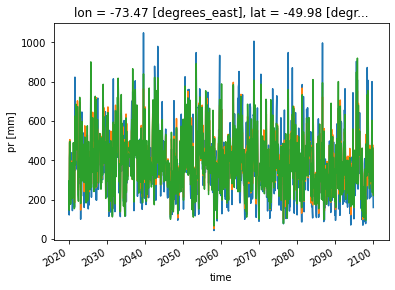

In [75]:
pp_model_ssp_bc.sel(lat = -50,  method='nearest').sel(lon = -73.5,  method='nearest').plot()
xr.open_dataset("/home/rooda/OGGM_results/Future_climate_bc/PP_ERA5_NorESM2-MM_ssp585_MVA.nc").pr.sel(lat = -50,  method='nearest').sel(lon = -73.5,  method='nearest').plot()
xr.open_dataset("/home/rooda/OGGM_results/Future_climate_bc/PP_ERA5_NorESM2-MM_ssp585_DQM.nc").pr.sel(lat = -50,  method='nearest').sel(lon = -73.5,  method='nearest').plot()

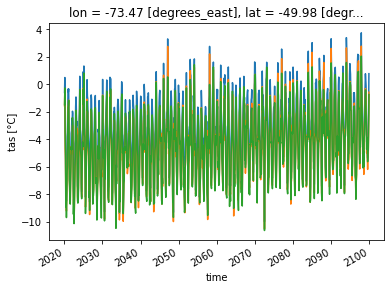

In [79]:
t2m_model_ssp_bc.sel(lat = -50,  method='nearest').sel(lon = -73.5,  method='nearest').plot()
xr.open_dataset("/home/rooda/OGGM_results/Future_climate_bc/T2M_ERA5_NorESM2-MM_ssp585_MVA.nc").tas.sel(lat = -50,  method='nearest').sel(lon = -73.5,  method='nearest').plot()
xr.open_dataset("/home/rooda/OGGM_results/Future_climate_bc/T2M_ERA5_NorESM2-MM_ssp585_DQM.nc").tas.sel(lat = -50,  method='nearest').sel(lon = -73.5,  method='nearest').plot()